<a href="https://colab.research.google.com/github/P-07nandini/Fmml/blob/main/FMML_Course_Topic_8_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Machine Learning: Lab 3 - Applying Bayes Classifiers

Lab by V Vijay Vignesh

vijay.vignesh@research.iiit.ac.in

In [1]:
import os
import json
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pg

import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
!wget https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
plt.style.use('ggplot')

--2024-03-25 16:09:51--  https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72422946 (69M) [text/plain]
Saving to: ‘arxiv-paper-data.json’

arxiv-paper-data.js 100%[===================>]  69.07M   123MB/s    in 0.6s    

2024-03-25 16:09:54 (123 MB/s) - ‘arxiv-paper-data.json’ saved [72422946/72422946]



Let's make a few assumptions to come up with our first general model for classification:
* The different features contribute equally to the result
* The features are independent

## Bayes Classifiers in Scikit Learn

### Simple 1-D Classfication using Naive Bayes in Continuous Space

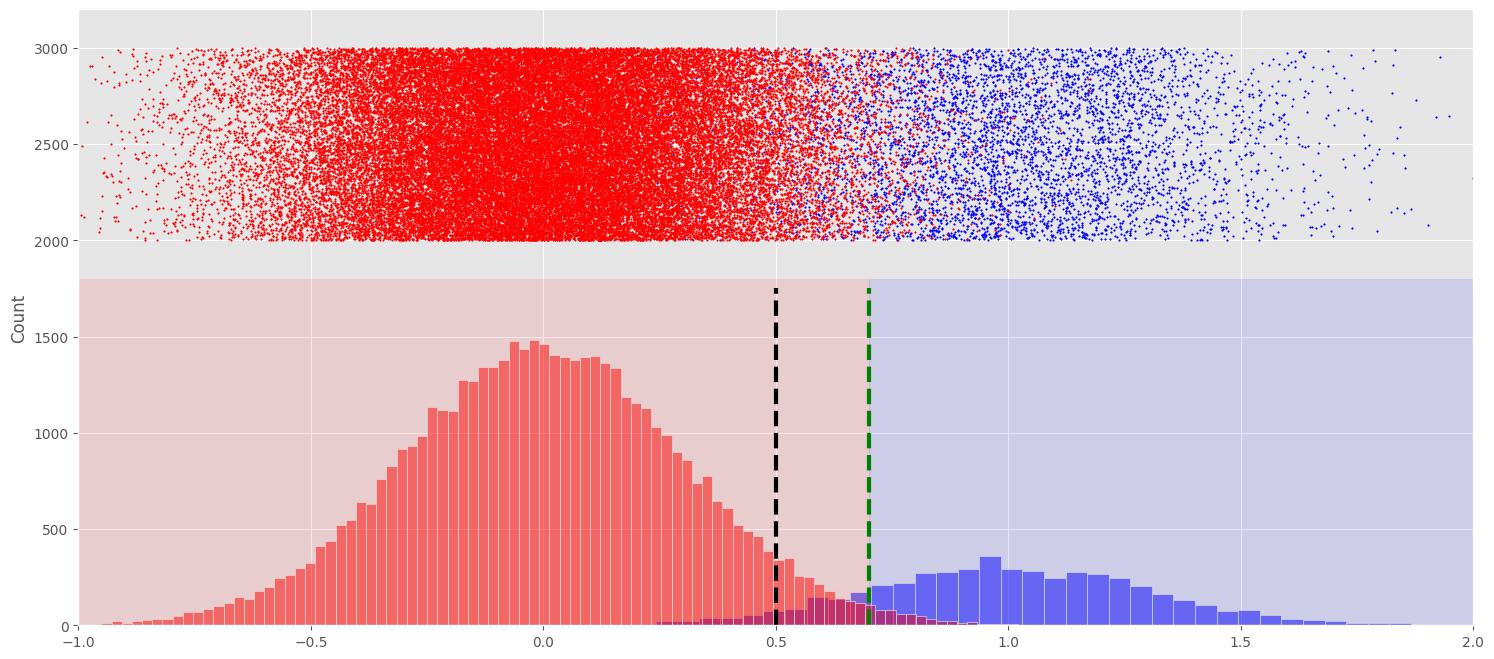

In [3]:
fig, ax = plt.subplots(figsize=(18, 8))
x1 = np.random.normal(1.0, 0.3, size=5000)
x2 = np.random.normal(0.0, 0.3, size=50000)
x = np.concatenate([x1, x2])
y = np.concatenate([np.zeros(len(x1)), np.ones(len(x2))])
sns.histplot(x1, color='blue', alpha=0.5, ax=ax)
sns.histplot(x2, color='red', alpha=0.5, ax=ax)
ax.fill_between(np.linspace(-1.0, 0.7, 100), 0, 1800,  color='r', alpha=0.1)
ax.fill_between(np.linspace(0.7, 2.0, 100), 0, 1800,  color='b', alpha=0.1)
ax.vlines(0.5, 0, 1750, color="k", linestyles="--", lw=3)
ax.vlines(0.7, 0, 1750, color="g", linestyles="--", lw=3)
ax.scatter(x1, [np.random.randint(2000, 3000) for _ in x1], color='b', s=1)
ax.scatter(x2, [np.random.randint(2000, 3000) for _ in x2], color='r', s=1)
ax.set_xlim(-1.0, 2.0)
ax.set_ylim(0, 3200)
plt.show()

In [4]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
x_reshaped = x.reshape(1, -1)
print(x_reshaped.shape)

(1, 55000)


## Gaussian Bayes Predictor on Predicting Flowers

### Predictors in Scikit Learn

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_iris(return_X_y=True)
X = X[:, [2, 3]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

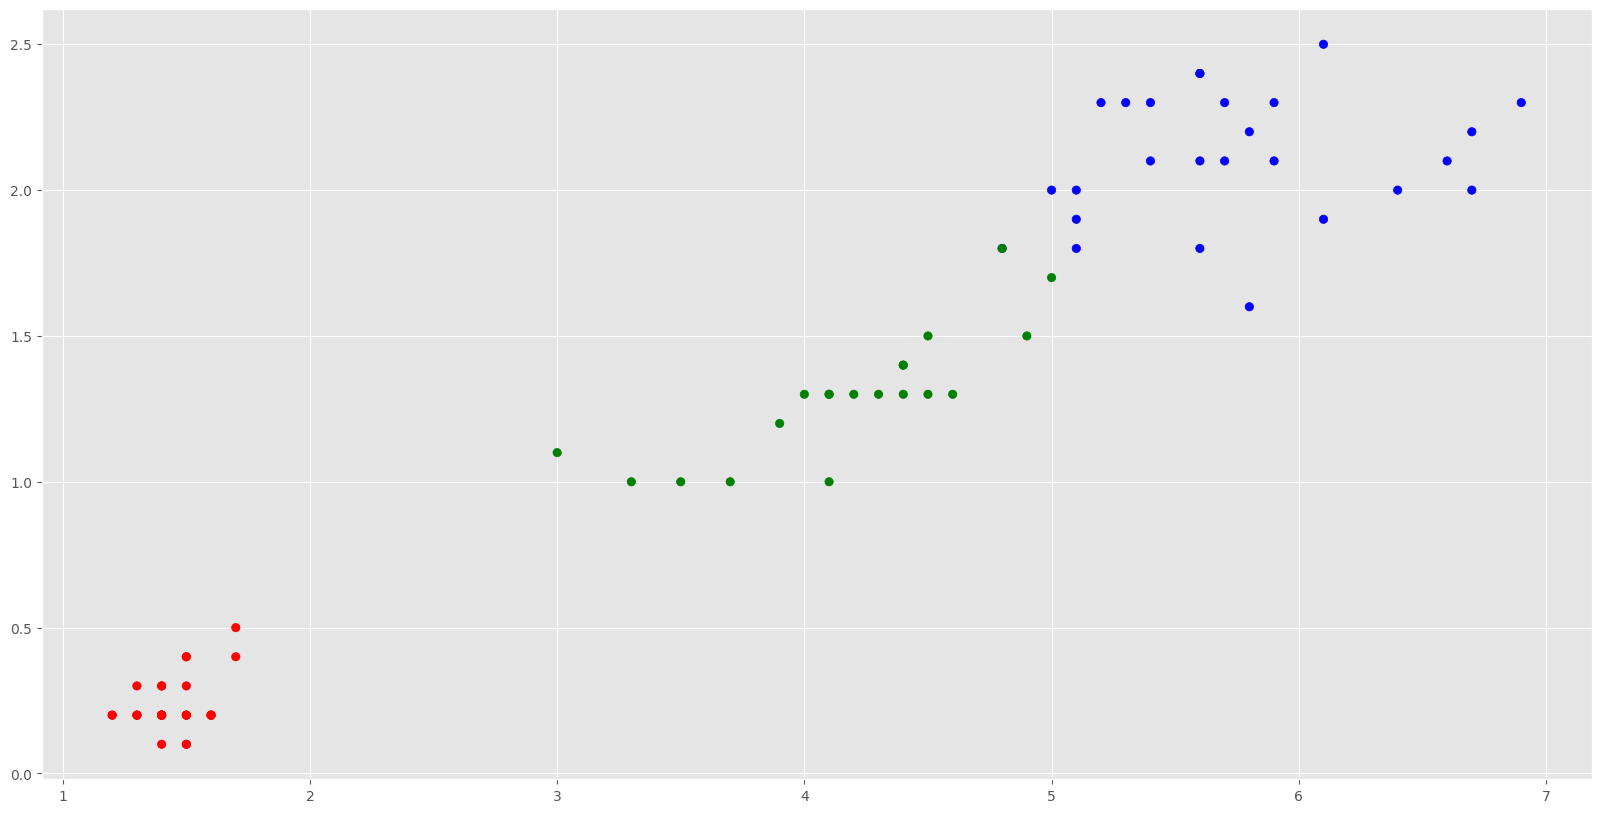

In [6]:
plt.figure(figsize=(20, 10))
color_scheme = ['red', 'green', 'blue']
plt.scatter(X_train[:, 0], X_train[:, 1], c=[color_scheme[idx] for idx in y_train])
plt.show()

### Visualizing the Decision Surface

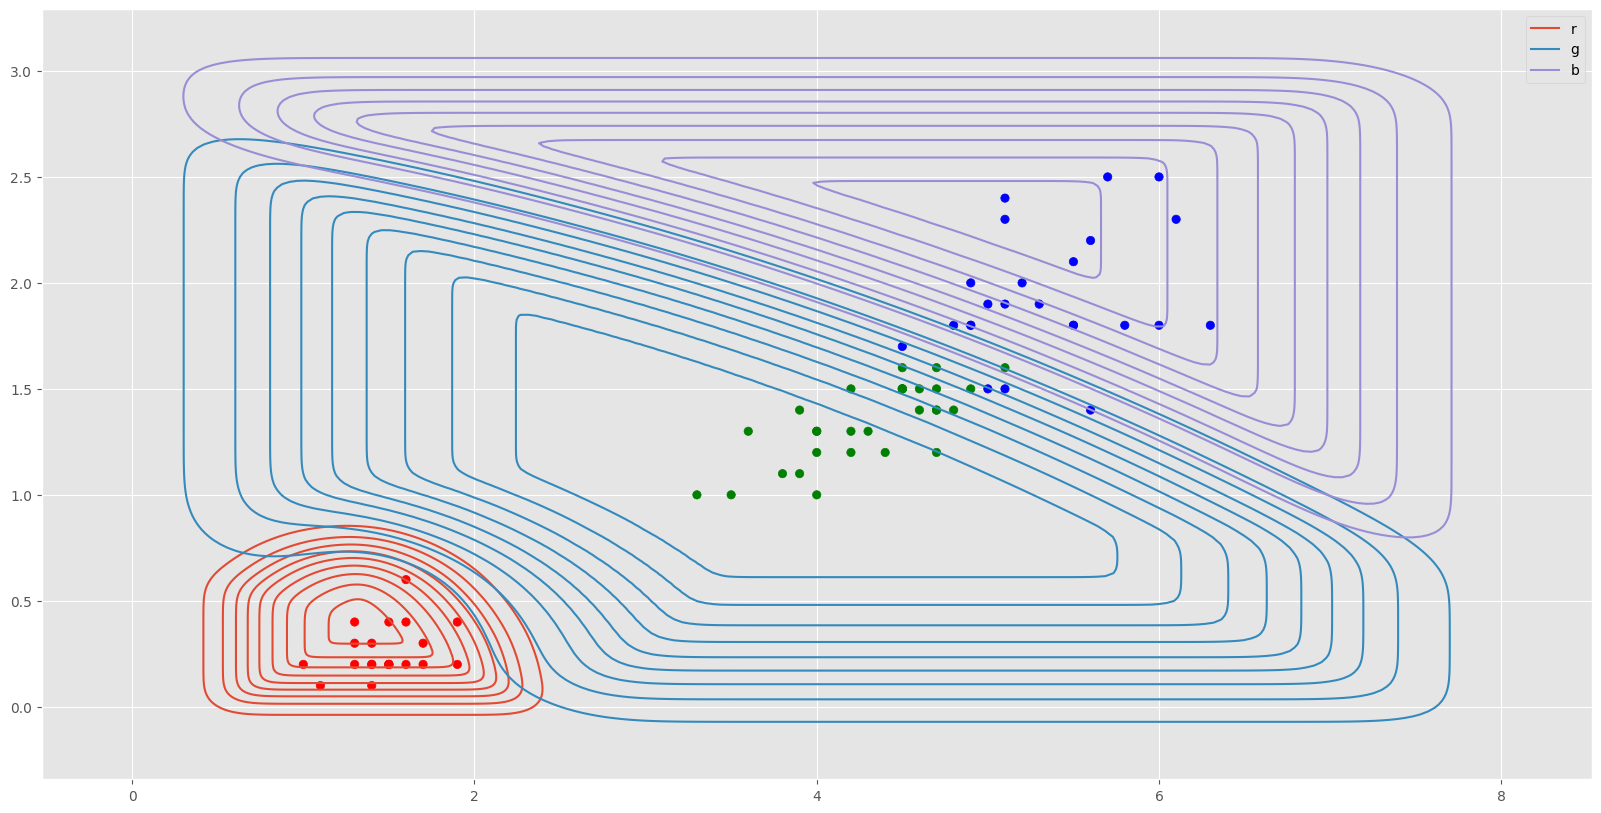

In [7]:
plt.figure(figsize=(20, 10))
X1_scan, X2_scan = np.meshgrid(np.linspace(0.5, 7.5, 250), np.linspace(0.0, 3.0, 250))
X_scan = np.stack([np.reshape(X1_scan, -1), np.reshape(X2_scan, -1)], axis=-1)
predictions = gnb.predict(X_scan)
color_map = ['r', 'g', 'b']
plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c=[color_map[x] for x in y_test])
sns.kdeplot(x=X_scan[:, 0], y=X_scan[:, 1], hue=[color_map[x] for x in predictions], fill=False)
plt.show()

## Bayes on Text - Classifying papers at Arxiv

### Data Cleaning and Preprocessing

In [8]:
arxiv_df = pd.read_json(open("arxiv-paper-data.json", 'r'))
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: json.loads(x.replace("\'", "\"").replace("None", "\"None\""))[0]['term'].split('.')[0])
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: 'physics' if x in ['physics', 'quant-ph', 'astro-ph', 'hep-ex', 'hep-ph', 'hep-lat', 'hep-th', 'nucl-th'] else x)
arxiv_df = arxiv_df.drop(["day", "month", "link", "author"], axis=1)

In [9]:
SAMPLES_COMP = 3500 #@param {type: "slider", min: 1000, max: 4500}
SAMPLES_STAT = 2500 #@param {type: "slider", min: 1000, max: 4500}
WORD_COUNT_THRESHOLD = 1  #@param {type: "slider", min: 1, max: 500}
WORD_LENGTH_THRESHOLD = 8  #@param {type: "slider", min: 4, max: 20}

In [10]:
df = pd.concat([arxiv_df[arxiv_df['tag'] == 'cs'].sample(SAMPLES_COMP, replace=False),
                arxiv_df[arxiv_df['tag'] == 'stat'].sample(SAMPLES_STAT, replace=False)]).sample(frac=1)
df['keywords'] = df.apply(lambda x: [word.lower() for word in re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', x.summary + ' ' + x.title)).split()
                                     if len(word) > WORD_LENGTH_THRESHOLD and not re.search('(\d|\(|\))', word)], axis=1)
train_df, test_df = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8):]

train_df

,id,summary,tag,title,year,keywords
5254,1204.6509v1,We introduce in this paper a new way of optimi...,stat,Dissimilarity Clustering by Hierarchical Multi...,2012,"[introduce, optimizing, extension, quantizatio..."
39908,1707.06068v1,"In this paper, we consider the problem of find...",cs,On Finding Maximum Cardinality Subset of Vecto...,2017,"[cardinality, constraint, normalized, differen..."
26136,1608.08334v2,Thanks to the availability and increasing popu...,cs,Egocentric Meets Top-view,2016,"[availability, increasing, popularity, egocent..."
29885,1710.11121v1,Magnetic Resonance Imaging (MRI) is an importa...,cs,Automated Tumor Segmentation and Brain Mapping...,2017,"[resonance, important, diagnostic, detection, ..."
1859,1711.05448v1,Recurrent neural network (RNN) language models...,stat,Lattice Rescoring Strategies for Long Short Te...,2017,"[recurrent, outperform, traditional, recogniti..."
...,...,...,...,...,...,...
21821,1212.1263v1,In this paper we prove the probabilistic conti...,stat,On the probabilistic continuous complexity con...,2012,"[probabilistic, continuous, complexity, conjec..."
34453,1609.01574v1,Clinicians are expected to have up-to-date and...,cs,"Automatically extracting, ranking and visually...",2016,"[clinicians, knowledge, treatment, knowledge, ..."
6681,1705.02737v3,Missing data is a significant problem impactin...,cs,MIDA: Multiple Imputation using Denoising Auto...,2017,"[significant, impacting, framework, minimizing..."
23234,1005.5439v1,Wireless Capsule Endoscopy (WCE) is device to ...,cs,Detection of Bleeding in Wireless Capsule Endo...,2010,"[endoscopy, abnormalities, colonesophagussmall..."


In [11]:
df['keywords']

5254     [introduce, optimizing, extension, quantizatio...
39908    [cardinality, constraint, normalized, differen...
26136    [availability, increasing, popularity, egocent...
29885    [resonance, important, diagnostic, detection, ...
1859     [recurrent, outperform, traditional, recogniti...
                               ...                        
10984    [applications, euclidean, partitioned, classif...
24375    [curvature, increased, attention, important, a...
37042    [constructs, represented, represented, constru...
32831    [constrained, algorithms, orthogonal, algorith...
21081    [resurgence, particular, assertions, unreasona...
Name: keywords, Length: 6000, dtype: object

### Learning Probability Distributions

In [12]:
from collections import defaultdict
dictionary = defaultdict(lambda: [0, 0])
for desc, tag in zip(df['keywords'], df['tag']):
    for word in set(desc):
        if tag == 'cs':
            dictionary[word][0] += 1
        else:
            dictionary[word][1] += 1

print("We have a dictionary of", len(dictionary), "words.")

words, counts_cs, counts_stat = [], [], []
for word, count in dictionary.items():
    if count[0] + count[1] > WORD_COUNT_THRESHOLD:
        words.append(word)
        counts_cs.append(count[0])
        counts_stat.append(count[1])
print("Out of those", len(words), f"have over {WORD_COUNT_THRESHOLD} occurances")

fig = pg.Figure([pg.Bar(x=words[:200], y=counts_cs[:200]),
                 pg.Bar(x=words[:200], y=counts_stat[:200])])
fig.update_layout(title_text=f'Some random words and the frequency plot of those with over {WORD_COUNT_THRESHOLD} occurances')
fig.show()

We have a dictionary of 8683 words.
Out of those 4553 have over 1 occurances


For each word, for both the subjects, we can apply Bayes rule.

$$P\bigg(\frac{\text{subject}}{\text{word}}\bigg) = P\bigg(\frac{\text{word}}{\text{subject}}\bigg) \times \frac{P(\text{subject})}{P(\text{word})}$$

### Computing the resultant probabilities

In [13]:
prior = np.array([train_df["tag"].value_counts()["cs"], train_df["tag"].value_counts()["stat"]]) / len(train_df)
evidence = np.array([counts_cs / train_df["tag"].value_counts()["cs"], counts_stat / train_df["tag"].value_counts()["stat"]]).T
likelihood = (np.array(counts_cs) + np.array(counts_stat)) / len(train_df)

prior.shape, likelihood.shape, evidence.shape

((2,), (4553,), (4553, 2))

In [14]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(
        np.multiply(this_counts.reshape(-1, 1), evidence), likelihood.reshape(-1, 1))) + 0.001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.7808333333333334


### Visualizing a few examples

In [15]:
def explain(example):
    from IPython.display import HTML
    title, desc, answer = example["title"], example["summary"], example["tag"]
    html = ""
    title = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', title)))
    desc = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', desc)))
    for text in [title, desc]:
        for word in text.split():
            idx = words_to_index[word.lower()]
            if idx == -1:
                html += f"<span style=''>{word}</span> "
            else:
                posterior = np.multiply(evidence[idx], prior)
                posterior /= np.sum(posterior)
                if posterior[0] > posterior[1] if answer == 'cs' else (posterior[0] <= posterior[1]):
                    color = max(0.3, posterior[0] - posterior[1])
                    html += f"<span style='background-color:rgba(0, 255, 0, {color});'>{word}</span> "
                else:
                    color = max(0.3, posterior[1] - posterior[0])
                    html += f"<span style='background-color:rgba(255, 0, 0, {color});'>{word}</span> "
        html += "<br/><br/>"
    return HTML(html)

In [16]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [17]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

In [18]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [19]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

### Visualizing the Learnt Words

In [20]:
print("Some Computer Science words are:")
for word_cs in np.argsort(evidence[:, 0] - evidence[:, 1])[-10:]:
    print(f"\t{words[word_cs]} ({evidence[word_cs, 0]})")
print()
print("Some Statistics words are:")
for word_st in np.argsort(evidence[:, 1] - evidence[:, 0])[-10:]:
    print(f"\t{words[word_st]} ({evidence[word_st, 1]})")

Some Computer Science words are:
	evaluation (0.0932902762827413)
	representation (0.13311804808037317)
	architecture (0.09006099748833872)
	segmentation (0.07499102978112666)
	experimental (0.14818801578758523)
	different (0.25905992106207393)
	information (0.2526013634732687)
	detection (0.12917115177610333)
	convolutional (0.14101184068891282)
	recognition (0.14137064944384642)

Some Statistics words are:
	stochastic (0.13065076999503228)
	algorithm (0.3914555389965226)
	estimation (0.17585692995529062)
	distribution (0.18777943368107303)
	variables (0.14704421261798312)
	theoretical (0.16443119721808247)
	statistical (0.16294088425235967)
	dimensional (0.18579234972677597)
	inference (0.21510183805265773)
	regression (0.18281172379533037)


## Probability Smoothing

Probability smoothing is a language modeling technique that assigns some non-zero probability to events that were unseen in the training data. This has the effect that the probability mass is divided over more events, hence the probability distribution becomes more smooth.

### Realizing the Problem

In [21]:
posterior = np.multiply(np.divide(evidence, np.reshape(likelihood, (-1, 1))), np.reshape(prior, (1, -1)))

fig = pg.Figure([pg.Bar(x=words, y=evidence[:20, 0]),
                 pg.Bar(x=words, y=posterior[:20, 0])])
fig.update_layout(title_text='Evidence and Posterior for each word')
fig.show()

In [22]:
print("Some words which never appear in Computer Science paper:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_cs) == 0)[0][:20]]))
print("Some words which never appear in Statistics papers:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_stat) == 0)[0][:20]]))

Some words which never appear in Computer Science paper:
	datastreams
	therapies
	integrative
	transports
	repulsive
	unmeasured
	truncation
	advantageously
	invertible
	differentiability
	inspecting
	discretisation
	reversing
	disproportionately
	california
	regressions
	collinearity
	semiparametric
	dimensionalities
	heteroscedasticity
Some words which never appear in Statistics papers:
	observers
	egocentric
	ethnicities
	intriguing
	deceptive
	dialogues
	manipulating
	neurobiology
	assistance
	pedestrian
	propositional
	satisfactory
	lukasiewicz
	propositions
	assistive
	accidents
	australian
	inspections
	autonomously
	continued


Notice the fact that there are cases where the Evidence $P\big(\frac{\text{word}}{\text{subject}}\big) \rightarrow 0$. This is because there are occurances of the given word in the corpus (all the abstract of papers put together) of that subject.

However, this is no way implies that if a word (eg. Employment) never occurs in our training corpus in a Computer Science paper, it will also never occur in a paper in the test set.

Therefore, setting $P(\text{word} | \text{subject}) = 0$ is incorrect, since it will make the posterior $P(\text{subject} | \text{word}) = 0$, even if the corresponding count it 0, we need to come up with a smoother formulation of the Evidence variables.

### Laplace Smoothing



https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece


3.0842303303210686e-05


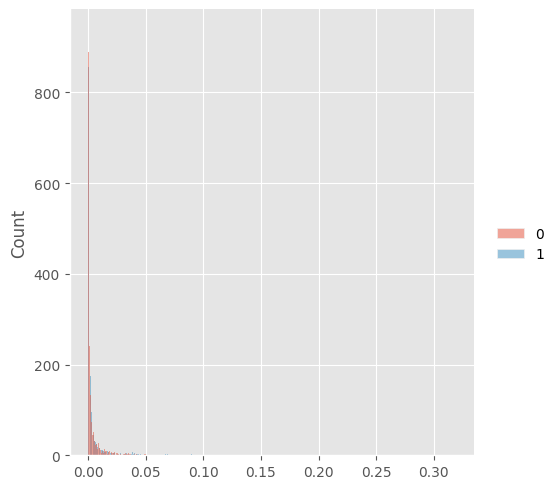

In [23]:
alpha = 0.1
counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                            (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T
print(np.min(evidence_smooth))
sns.displot(evidence_smooth)

In [24]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(np.multiply(this_counts.reshape(-1, 1), evidence_smooth), likelihood.reshape(-1, 1))) + 0.0000001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.7408333333333333
